In [1]:
import pandas as pd 
from pathlib import Path 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 

DATA = Path("./data/")

df = pd.read_csv(DATA / "set_7.csv")

In [2]:
#train/test 
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
df_train = train.copy()

In [4]:
df_train.shape[0]

12000

In [5]:
#correlatin 

corr_matrix = df_train.corr(numeric_only=True)

corr_matrix['Calories'].sort_values(ascending=False)

Calories      1.000000
Duration      0.955173
Heart_Rate    0.897399
Body_Temp     0.824817
Age           0.153091
Weight        0.035417
Height        0.015936
User_ID       0.004108
Name: Calories, dtype: float64

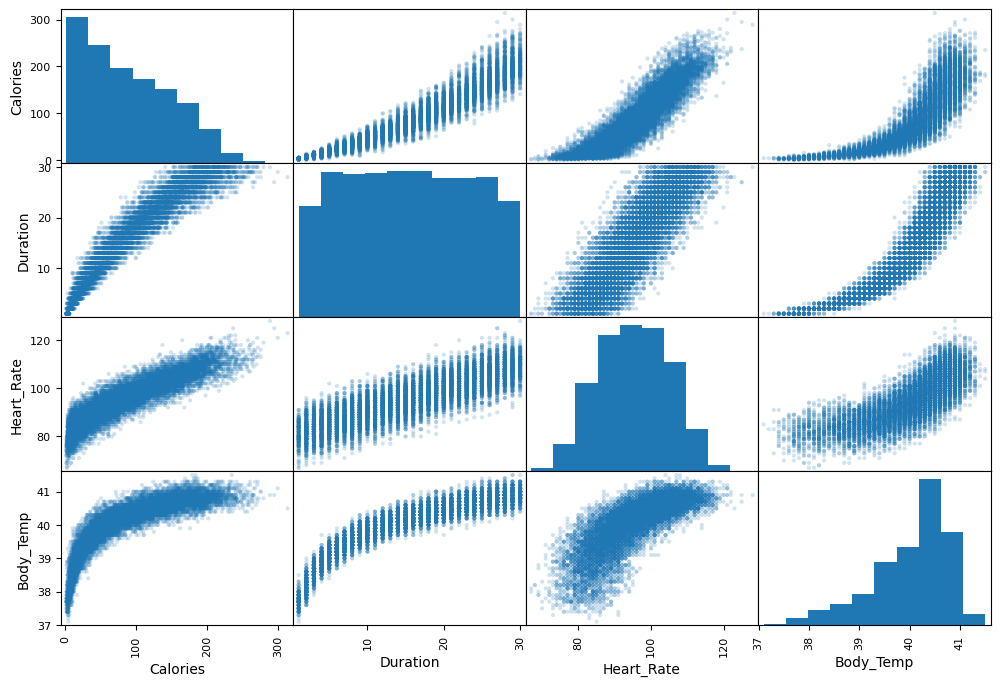

In [6]:
from pandas.plotting import scatter_matrix 

attributes = ["Calories", "Duration","Heart_Rate", "Body_Temp"]
scatter_matrix(df_train[attributes], figsize=(12, 8), alpha=0.2)
plt.savefig("out/img/features.png", dpi=300)
plt.show()

In [7]:
#labels and the rest 

df_train = train.drop("Calories", axis=1)
df_train_labels = train["Calories"].copy()

In [8]:
#cleaning 

df_train.isna().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64

In [9]:
#num data 
df_train_num = df_train.select_dtypes(include=[np.number])

Emissions Сheck

In [10]:
 # emissions
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(df_train_num)

In [11]:
outlier_pred 

array([ 1, -1,  1, ...,  1,  1,  1])

In [12]:
count_outlier = pd.DataFrame(outlier_pred, columns=["outlier_flag"], index=df_train_num.index)
count_outlier.value_counts()

outlier_flag
 1              8714
-1              3286
Name: count, dtype: int64

In [13]:
# df_train = df_train.iloc[outlier_pred == 1]
# df_train_labels = df_train_labels.iloc[outlier_pred == 1]

Pipeline

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

 # Automatic feature selection by type
numeric_features = make_column_selector(dtype_include='number')
categorical_features = make_column_selector(dtype_include='object')

 # Pipeline for numerical features
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

 # Pipeline for categorical features
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


full_pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', numeric_pipeline, numeric_features),
        ('categorical', categorical_pipeline, categorical_features),
    ])
)


Model Training

LinearRegression

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(full_pipeline, LinearRegression())
lin_reg.fit(df_train, df_train_labels)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD3E5F3770>),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD3C775640>)]))])),
                ('linearregression', LinearRegression())])

In [16]:
predictions = lin_reg.predict(df_train)

In [17]:
from sklearn.metrics import mean_absolute_error

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False)

lin_rmse = root_mean_squared_error(df_train_labels, predictions)
lin_mae = mean_absolute_error(df_train_labels, predictions)

print(f"RMSE: {lin_rmse}")
print(f"MAE: {lin_rmse}")

RMSE: 11.265861143946857
MAE: 11.265861143946857


In [18]:
#cross-valid 
from sklearn.model_selection import cross_val_score

lin_rmses = -cross_val_score(lin_reg, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
lin_maes = -cross_val_score(lin_reg, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=10)

print("Average RMSE:", lin_rmses.mean())
print("Average MAE:", lin_maes.mean())

Average RMSE: 11.276239336176799
Average MAE: 8.31358966191084


Polynomial Regression

In [19]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = make_pipeline(
    full_pipeline,                     
    PolynomialFeatures(
        degree=2,                     
        include_bias=False
    ),
    LinearRegression()
)

 # training
poly_reg.fit(df_train, df_train_labels)

 # train predictions
poly_predictions = poly_reg.predict(df_train)


In [20]:
from sklearn.metrics import mean_absolute_error

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, poly_predictions, squared=False)

poly_rmse = root_mean_squared_error(df_train_labels, poly_predictions)
poly_mae = mean_absolute_error(df_train_labels, poly_predictions)

print(f"RMSE: {poly_rmse}")
print(f"MAE: {poly_rmse}")

RMSE: 2.9746634155619502
MAE: 2.9746634155619502


In [21]:
#cross-valid 
from sklearn.model_selection import cross_val_score

poly_rmses = -cross_val_score(poly_reg, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
poly_maes = -cross_val_score(poly_reg, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=10)

print("Average RMSE:", poly_rmses.mean())
print("Average MAE:", poly_maes.mean())

Average RMSE: 2.9933578664038456
Average MAE: 2.214425493172425


RandomForestRegressor

In [22]:
from sklearn.ensemble import RandomForestRegressor

 # creating a pipeline: preprocessing + random forest
rf_reg = make_pipeline(
    full_pipeline,
    RandomForestRegressor(
        n_estimators=100, # number of trees
        max_depth=15, # tree depth (None = all the way)
        min_samples_split=2, # minimum number of objects to split
        random_state=42,
        n_jobs=-1 # use all processor cores
    )
)

 # learning from training data
rf_reg.fit(df_train, df_train_labels)

 # predictions
forest_predictions = rf_reg.predict(df_train)

In [23]:
from sklearn.metrics import mean_absolute_error

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, forest_predictions, squared=False)

rf_rmse = root_mean_squared_error(df_train_labels, forest_predictions)
rf_mae = mean_absolute_error(df_train_labels, forest_predictions)

print(f"RMSE: {rf_rmse}")
print(f"MAE: {rf_rmse}")

RMSE: 1.1621303123815123
MAE: 1.1621303123815123


In [24]:
#cross-valid 
from sklearn.model_selection import cross_val_score

rf_rmses = -cross_val_score(rf_reg, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=3)
rf_maes = -cross_val_score(rf_reg, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=3)

print("Average RMSE:", rf_rmses.mean())
print("Average MAE:", rf_maes.mean())

Average RMSE: 3.428188915585857
Average MAE: 2.1551699993176934


Random Search and Best Model 

RS for RF

In [25]:
entire_pipeline_rf = Pipeline([
    ("preprocessing", full_pipeline),
    ("rf", RandomForestRegressor()),
])

#witch params there are
print(str(entire_pipeline_rf.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'rf', 'preprocessing__memory', 'preprocessing__steps', 'preprocessing__verbose', 'preprocessing__columntransformer', 'preprocessing__columntransformer__force_int_remainder_cols', 'preprocessing__columntransformer__n_jobs', 'preprocessing__columntransformer__remainder', 'preprocessing__columntransformer__sparse_threshold', 'preprocessing__columntransformer__transformer_weights', 'preprocessing__columntransformer__transformers', 'preprocessing__columntransformer__verbose', 'preprocessing__columntransformer__verbose_feature_names_out', 'preprocessing__columntransformer__numeric', 'preprocessing__columntransformer__categorical', 'preprocessing__columntransformer__numeric__memory', 'preprocessing__columntransformer__numeric__steps', 'preprocessing__columntransformer__numeric__verbose', 'preprocessing__columntransformer__numeric__imputer', 'preprocessing__columntransformer__numeric__scaler', 'preprocessing__columntransformer__numeric_

In [26]:
#random research 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    "rf__n_estimators": randint(100, 600), # number of trees
    "rf__max_depth": [None, 5, 10, 20, 30], # tree depth
    "rf__min_samples_split": randint(2, 10), # minimum number of objects to split
    "rf__min_samples_leaf": randint(1, 5), # minimum number of objects in a sheet
    "rf__max_features": ["sqrt", "log2", None], # feature selection strategy
    "rf__bootstrap": [True, False], # use bootstrap?
    "rf__n_jobs": [-1], # use all cores
    "rf__random_state": [42], # for reproducibility
}

rnd_search = RandomizedSearchCV(
    entire_pipeline_rf, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(df_train, df_train_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('numeric',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD3E5F3770>),
                                                                                               ('categorical',
                                                                                                Pipeline(st...
                                        'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FD3E6B09B0>,
                                        'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FD3BAA03B0>,
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FD3C6BCA10>,
                                        'rf__n_jobs': [-1],
                                        'rf__random_state': [42]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [27]:
rnd_search.best_params_

{'rf__bootstrap': True,
 'rf__max_depth': 30,
 'rf__max_features': None,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 4,
 'rf__n_estimators': 314,
 'rf__n_jobs': -1,
 'rf__random_state': 42}

In [28]:
best_rf = rnd_search.best_estimator_
predictions = best_rf.predict(df_train)

In [29]:
best_rmses = -cross_val_score(best_rf, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
best_maes = -cross_val_score(best_rf, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=3)                              
print(f"best_rmses: {pd.Series(best_rmses).mean()}")
print(f"best_maes: {pd.Series(best_maes).mean()}")

best_rmses: 3.084748367695746
best_maes: 2.1485037543541323


In [ ]:
#Test
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

X_test = test.drop("Calories", axis=1)
y_test = test["Calories"].copy()

final_predictions_rf = best_rf.predict(X_test)

 # ===Metrics ===
final_rmse = root_mean_squared_error(y_test, final_predictions_rf)
final_mae = mean_absolute_error(y_test, final_predictions_rf)

print(f"RMSE: {final_rmse:.2f}")
print(f"MAE:  {final_mae:.2f}")


RMSE: 2.83
MAE:  1.80


RS for LR

In [31]:
entire_pipeline_lr = Pipeline([
    ("preprocessing", full_pipeline),
    ("linear_regression", LinearRegression()),
])

#witch params there are
print(str(entire_pipeline_lr.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'linear_regression', 'preprocessing__memory', 'preprocessing__steps', 'preprocessing__verbose', 'preprocessing__columntransformer', 'preprocessing__columntransformer__force_int_remainder_cols', 'preprocessing__columntransformer__n_jobs', 'preprocessing__columntransformer__remainder', 'preprocessing__columntransformer__sparse_threshold', 'preprocessing__columntransformer__transformer_weights', 'preprocessing__columntransformer__transformers', 'preprocessing__columntransformer__verbose', 'preprocessing__columntransformer__verbose_feature_names_out', 'preprocessing__columntransformer__numeric', 'preprocessing__columntransformer__categorical', 'preprocessing__columntransformer__numeric__memory', 'preprocessing__columntransformer__numeric__steps', 'preprocessing__columntransformer__numeric__verbose', 'preprocessing__columntransformer__numeric__imputer', 'preprocessing__columntransformer__numeric__scaler', 'preprocessing__columntransf

In [32]:
#random research 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'preprocessing__columntransformer__remainder': ['drop', 'passthrough'],
    'preprocessing__columntransformer__sparse_threshold': [0.0, 0.3, 0.5, 1.0],
    'linear_regression__fit_intercept': [True, False]
}

rnd_search = RandomizedSearchCV(
    entire_pipeline_lr, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(df_train, df_train_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('numeric',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD3E5F3770>),
                                                                                               ('categorical',
                                                                                                Pipeline(st...
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD3C775640>)]))])),
                                             ('linear_regression',
                                              LinearRegression())]),
                   param_distributions={'linear_regression__fit_intercept': [True,
                                                                             False],
                                        'preprocessing__columntransformer__remainder': ['drop',
                                                                                        'passthrough'],
                                        'preprocessing__columntransformer__sparse_threshold': [0.0,
                                                                                               0.3,
                                                                                               0.5,
                                                                                               1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [33]:
rnd_search.best_params_

{'preprocessing__columntransformer__sparse_threshold': 1.0,
 'preprocessing__columntransformer__remainder': 'drop',
 'linear_regression__fit_intercept': False}

In [34]:
best_lr = rnd_search.best_estimator_
predictions_lr = best_lr.predict(df_train)

In [35]:
best_rmses = -cross_val_score(best_lr, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
best_maes = -cross_val_score(best_lr, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=3)                              
print(f"best_rmses: {pd.Series(best_rmses).mean()}")
print(f"best_maes: {pd.Series(best_maes).mean()}")

best_rmses: 11.276239336585572
best_maes: 8.312348775979826


In [ ]:
#Test
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

final_predictions_lr = best_lr.predict(X_test)

 # ===Metrics ===
final_rmse = root_mean_squared_error(y_test, final_predictions_lr)
final_mae = mean_absolute_error(y_test, final_predictions_lr)

print(f"RMSE: {final_rmse:.2f}")
print(f"MAE:  {final_mae:.2f}")


RMSE: 11.49
MAE:  8.44


RS for PR

In [37]:
entire_pipeline_pr = Pipeline([
    ('preprocessing', full_pipeline),
    ('poly', PolynomialFeatures()),
    ('lin_reg', LinearRegression())
])

#witch params there are
print(str(entire_pipeline_pr.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'poly', 'lin_reg', 'preprocessing__memory', 'preprocessing__steps', 'preprocessing__verbose', 'preprocessing__columntransformer', 'preprocessing__columntransformer__force_int_remainder_cols', 'preprocessing__columntransformer__n_jobs', 'preprocessing__columntransformer__remainder', 'preprocessing__columntransformer__sparse_threshold', 'preprocessing__columntransformer__transformer_weights', 'preprocessing__columntransformer__transformers', 'preprocessing__columntransformer__verbose', 'preprocessing__columntransformer__verbose_feature_names_out', 'preprocessing__columntransformer__numeric', 'preprocessing__columntransformer__categorical', 'preprocessing__columntransformer__numeric__memory', 'preprocessing__columntransformer__numeric__steps', 'preprocessing__columntransformer__numeric__verbose', 'preprocessing__columntransformer__numeric__imputer', 'preprocessing__columntransformer__numeric__scaler', 'preprocessing__columntransfor

In [38]:
# random research
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    "poly__degree": randint(2, 5),          
    "poly__include_bias": [True, False],   
    "lin_reg__fit_intercept": [True, False] 
}

rnd_search = RandomizedSearchCV(
    entire_pipeline_pr,                  
    param_distributions=param_distribs,
    n_iter=10,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=42
)

rnd_search.fit(df_train, df_train_labels)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('numeric',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD3E5F3770>),
                                                                                               ('categorical',
                                                                                                Pipeline(st...
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD3C775640>)]))])),
                                             ('poly', PolynomialFeatures()),
                                             ('lin_reg', LinearRegression())]),
                   param_distributions={'lin_reg__fit_intercept': [True, False],
                                        'poly__degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FD3E734B30>,
                                        'poly__include_bias': [True, False]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [39]:
rnd_search.best_params_

{'lin_reg__fit_intercept': False,
 'poly__degree': 3,
 'poly__include_bias': False}

In [40]:
best_pr = rnd_search.best_estimator_
predictions_pr = best_pr.predict(df_train)

In [ ]:
best_rmses = -cross_val_score(best_pr, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
best_maes = -cross_val_score(best_pr, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=3)                              
print(f"best_rmses: {pd.Series(best_rmses).mean()}")
print(f"best_maes: {pd.Series(best_maes).mean()}")

best_rmses: 0.29275417360064554
best_maes: 0.2535367107888626


In [ ]:
#test
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

final_predictions_pr = best_pr.predict(X_test)

 # ===Metrics ===
final_rmse = root_mean_squared_error(y_test, final_predictions_pr)
final_mae = mean_absolute_error(y_test, final_predictions_pr)

print(f"RMSE: {final_rmse:.2f}")
print(f"MAE:  {final_mae:.2f}")


RMSE: 0.29
MAE:  0.25


Visualization


In [43]:
models = {
    "Linear Regression": best_lr,
    "Poly Reg (with feat)": best_pr,
    "Random Forest": best_rf,
}

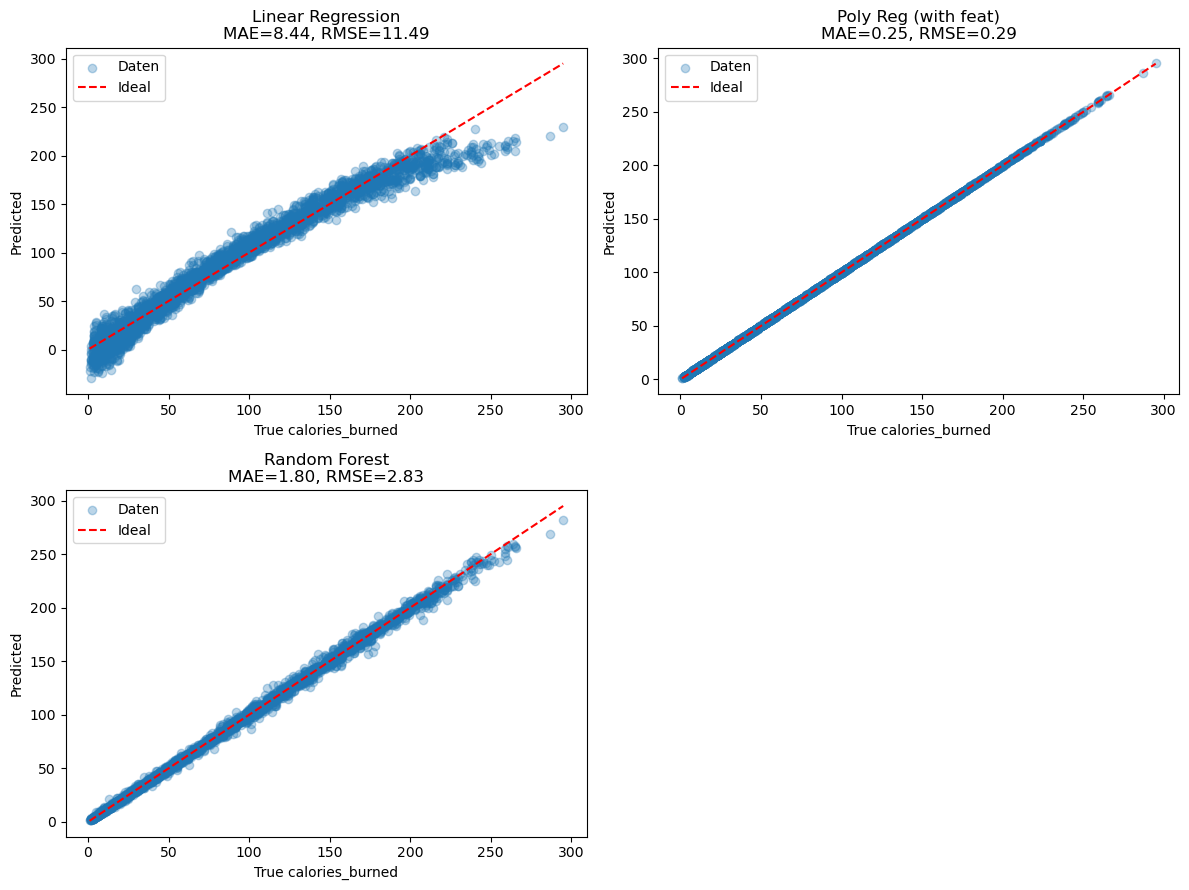

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.figure(figsize=(12, 9))

for i, (name, model) in enumerate(models.items(), start=1):
 # predictions
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

 # subgraph
    ax = plt.subplot(2, 2, i) # if there are 4 models; adjust if less/more
    ax.scatter(y_test, y_pred, alpha=0.3, label="Daten")
    ax.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            linestyle="--", color='red', label="Ideal")
    ax.set_xlabel("True calories_burned")
    ax.set_ylabel("Predicted")
    ax.set_title(f"{name}\nMAE={mae:.2f}, RMSE={rmse:.2f}")
    ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig("out/img/True vs Predicted.png", dpi=300)
plt.show()


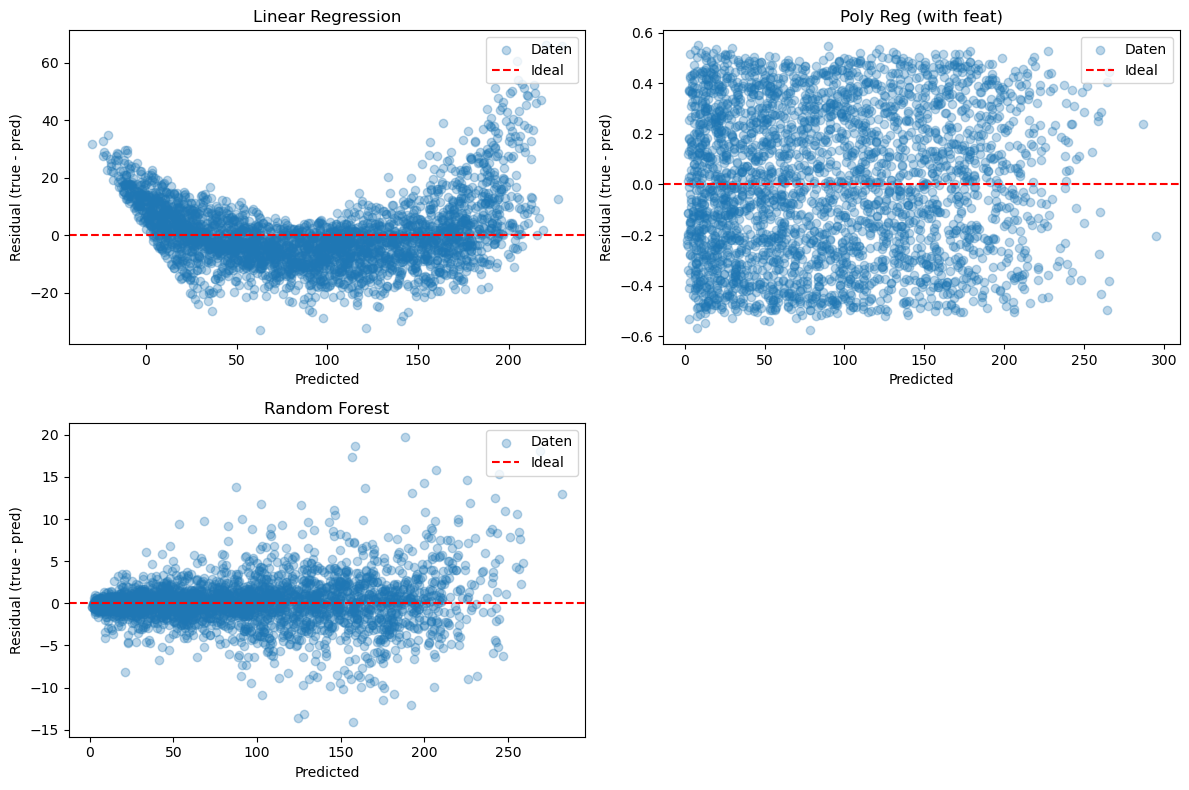

In [46]:
plt.figure(figsize=(12, 8))

for i, (name, model) in enumerate(models.items(), start=1):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    ax = plt.subplot(2, 2, i)
    ax.scatter(y_pred, residuals, alpha=0.3, label="Daten")
    ax.axhline(0, linestyle="--", color='red', label="Ideal")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residual (true - pred)")
    ax.set_title(name)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig("out/img/Residuals vs Predicted.png", dpi=300)
plt.show()
